In [2]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split



In [3]:
training_vars = ['jet_pt', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']
gbdt_filename = './gbdt.model'

sample_all_jets_path = '../../../samples/sample_allpt_all_jets.pkl'
sample_path = '../../../samples/sample_allpt_12M_jets.pkl'

label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]

n_estimators = 30 
learning_rate = 1.0 
max_depth = 2

# Load Data

In [4]:
sample_path = '../../../samples/sample_allpt_12M_jets.pkl'
sample = pd.read_pickle(sample_path)

In [5]:
sample.columns

Index(['jet_pt', 'jet_eta', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1',
       'jet_trackBDT', 'jet_PartonTruthLabelID', 'equal_weight',
       'event_weight', 'flatpt_weight', 'is_forward', 'pt_idx', 'target'],
      dtype='object')

# Train with default config

In [6]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [7]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [8]:
X_train[training_vars].head()

,jet_pt,jet_nTracks,jet_trackWidth,jet_trackC1
8091347,531.234863,13.0,0.014092,0.166602
6210831,1103.663452,25.0,0.031219,0.216386
1524473,1442.918823,15.0,0.014858,0.088302
13948873,523.586853,15.0,0.062496,0.134028
12416991,540.538818,16.0,0.053047,0.196087


In [9]:
X_train[training_weight].head()

,equal_weight
8091347,1.0
6210831,1.0
1524473,1.0
13948873,1.0
12416991,1.0


In [11]:
bdt = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, 
                                 max_depth=max_depth, random_state=42, verbose=1)

bdt.fit(X_dev[training_vars], y_dev, sample_weight=X_dev[training_weight].to_numpy().flatten())

### 

      Iter       Train Loss   Remaining Time 
         1           1.1028            3.09m
         2           1.0705            2.76m
         3           1.0605            2.34m
         4           1.0545            2.00m
         5           1.0502            1.67m
         6           1.0478            1.34m
         7           1.0457            1.01m
         8           1.0434           39.96s
         9           1.0419           19.85s
        10           1.0396            0.00s


GradientBoostingClassifier(learning_rate=1.0, max_depth=2, n_estimators=10,
                           random_state=42, verbose=1)

In [12]:
pickle.dump(bdt, open(gbdt_filename, 'wb'))

# Predict on test datasets

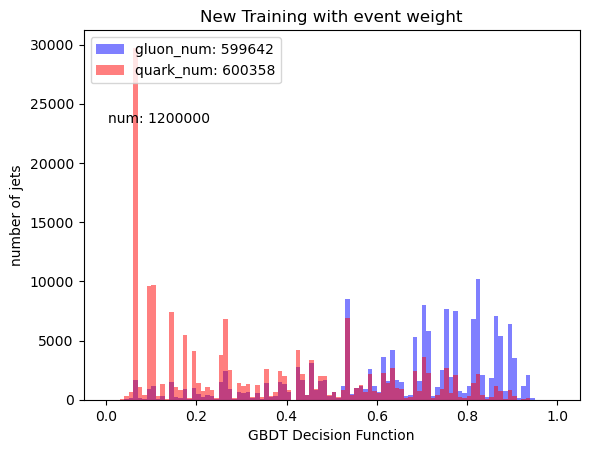

In [36]:
y_test_decisions = bdt.predict_proba(X_test[training_vars])[:,1]
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(0, 1, 101)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("GBDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with event weight")
plt.savefig("GBDT_Training.png")
plt.show()

# ROC

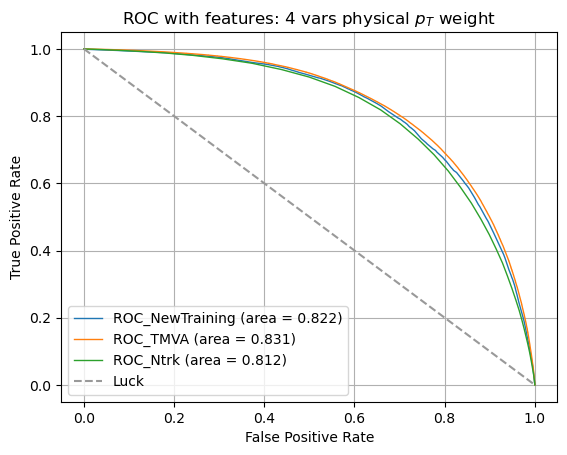

In [14]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig("ROC.png")
    plt.show()

Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')] , y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], X_weight=X_test['event_weight'], features=" 4 vars")


# Overtrain validation

Text(0.5, 1.0, 'Overtraining test')

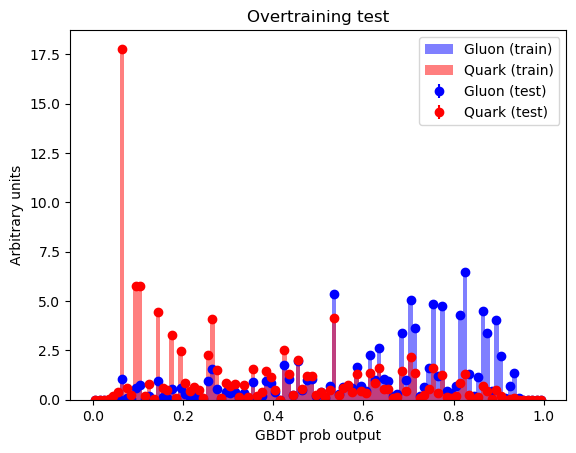

In [21]:
y_test_decisions = bdt.predict_proba(X_test[training_vars])[:,1]
y_dev_decisions = bdt.predict_proba(X_dev[training_vars])[:,1]


y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_dev_decisions_gluon = y_dev_decisions[np.where(y_dev==1)]
y_dev_decisions_quark = y_dev_decisions[np.where(y_dev==0)]
decisions = []
decisions.append(y_dev_decisions_gluon)
decisions.append(y_dev_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)

custom_bins = np.linspace(0, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(decisions[0], weights = X_dev.iloc[np.where(y_dev==1)[0], event_weight_idx],
            color='b', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Gluon (train)')
ax.hist(decisions[1], weights = X_dev.iloc[np.where(y_dev==0)[0], event_weight_idx],
            color='r', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Quark (train)')

hist, bins = np.histogram(decisions[2], weights=X_test.iloc[np.where(y_test==1)[0], event_weight_idx],
                            bins=custom_bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='b', label='Gluon (test)')

hist, bins = np.histogram(decisions[3], weights=X_test.iloc[np.where(y_test==0)[0], event_weight_idx],
                            bins=custom_bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale


plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='r', label='Quark (test)')
plt.xlabel("GBDT prob output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")

# Test Extraction on Current Sample

## inclusive

### feature distribution

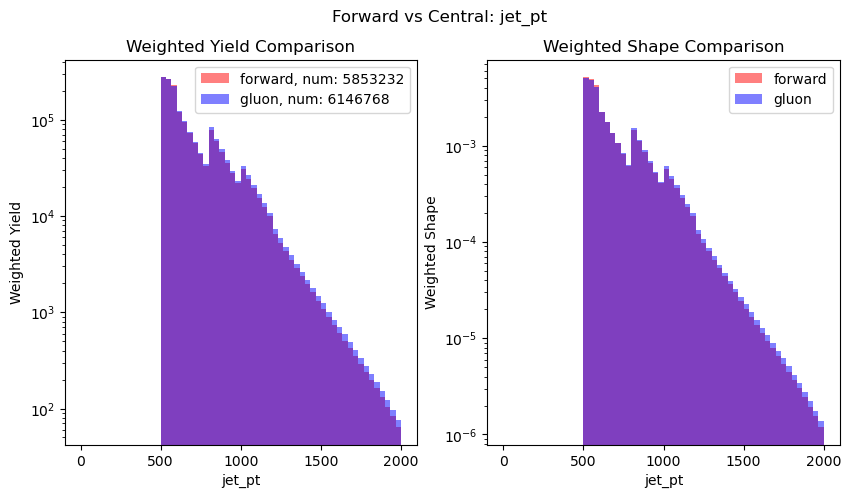

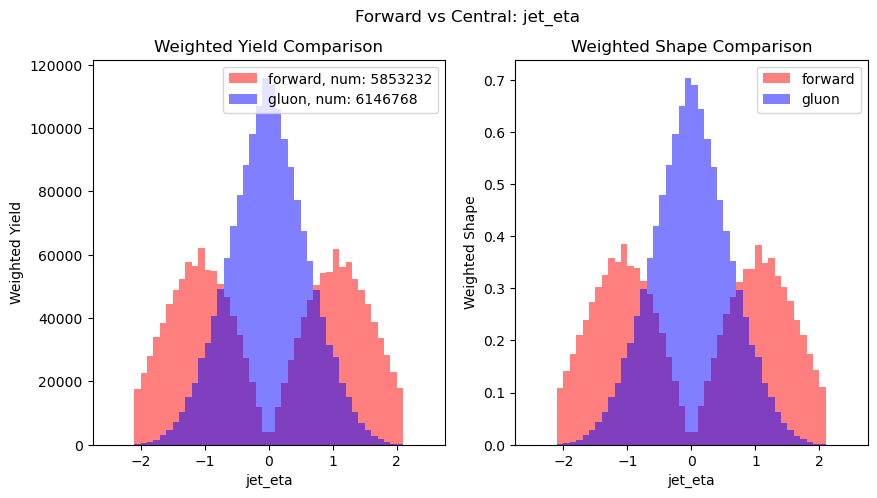

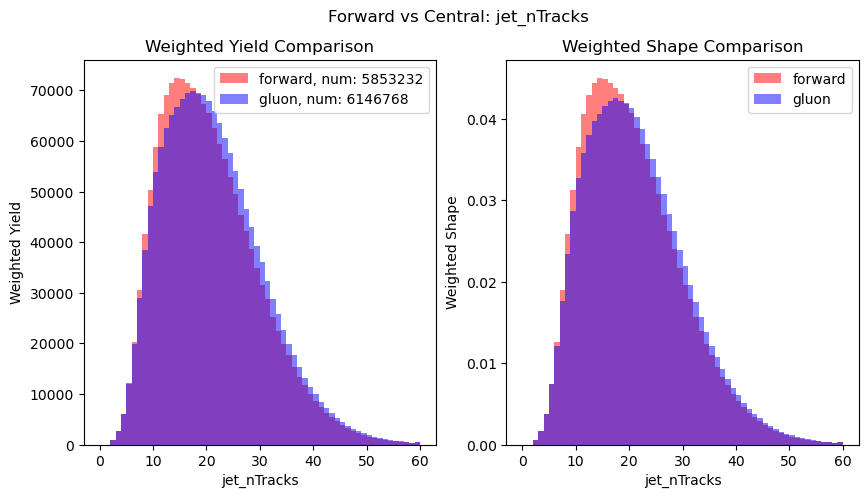

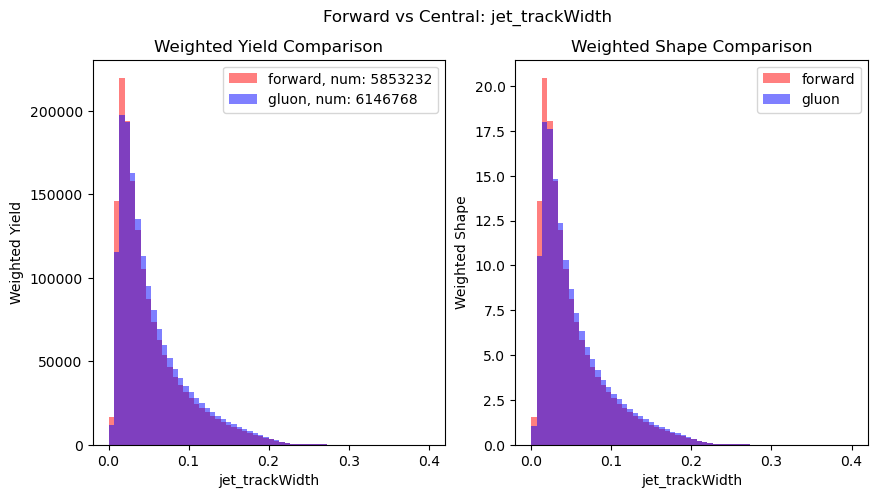

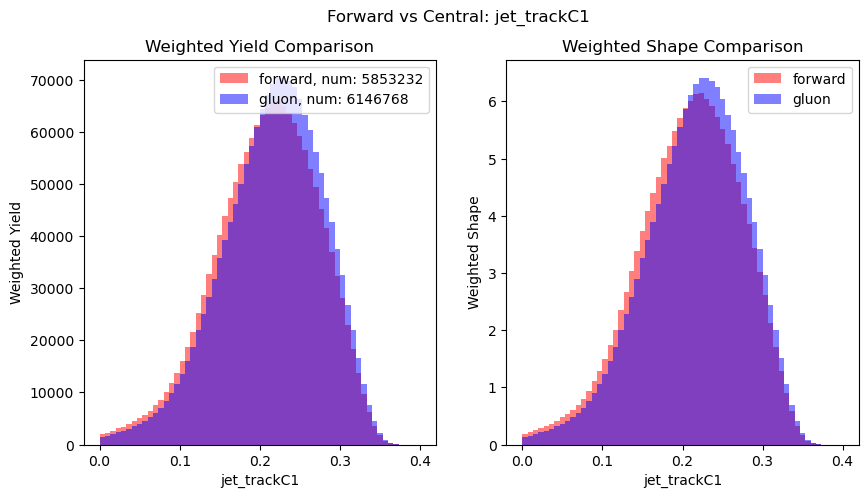

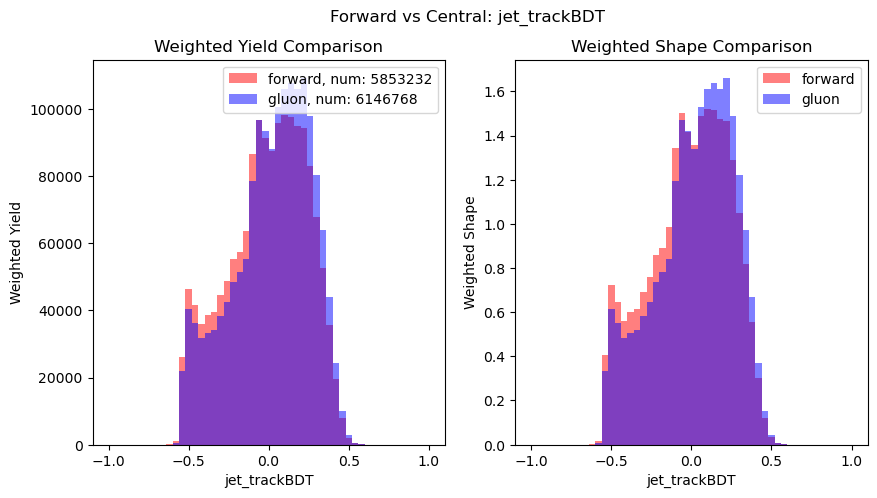

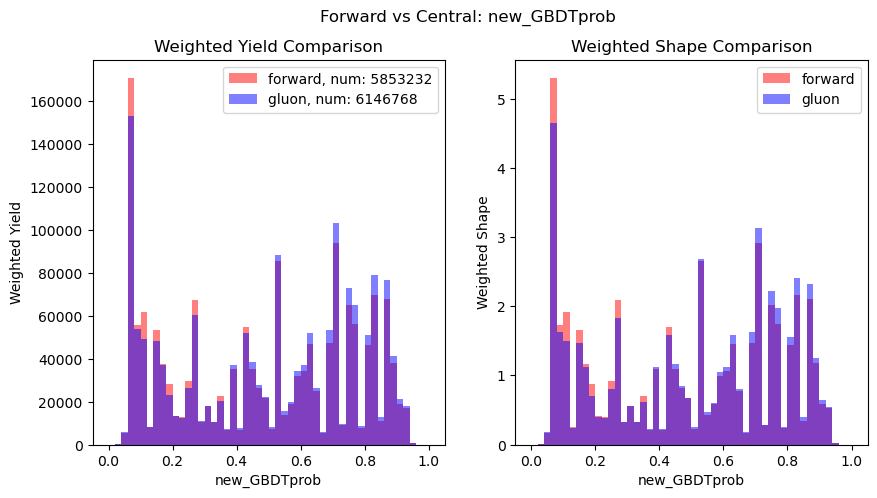

In [22]:
y_sample = bdt.predict_proba(sample[training_vars])[:,1]
sample['new_GBDTprob'] = y_sample

features = [*sample.columns[:6]] + ['new_GBDTprob'] 
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-1.0, 1.0, 51), 
    features[6] : np.linspace(0.0, 1.0, 51),
}

sample_forward = sample[sample['is_forward']==1]
sample_central = sample[sample['is_forward']==0]

for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
    ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'gluon, num: {len(sample_central)}', color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
    ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'gluon', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"Forward vs Central: {feature_name}")

    plt.plot()
    

### test extraction

Text(0.5, 0.98, 'new_GBDTprob')

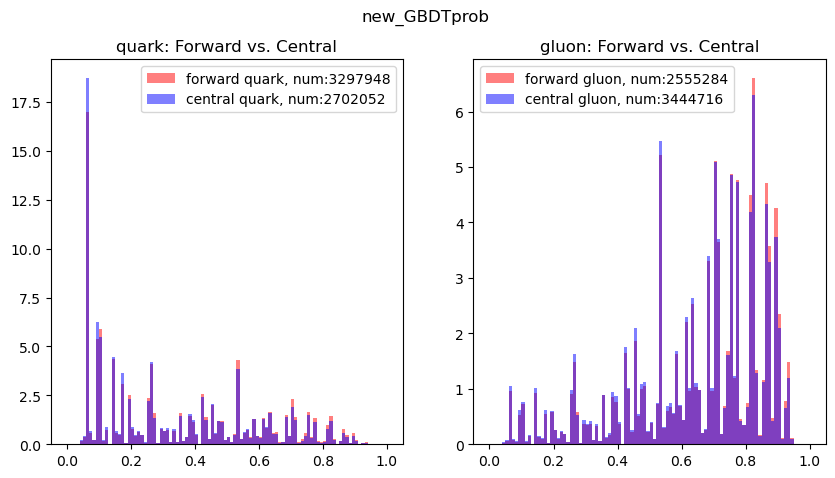

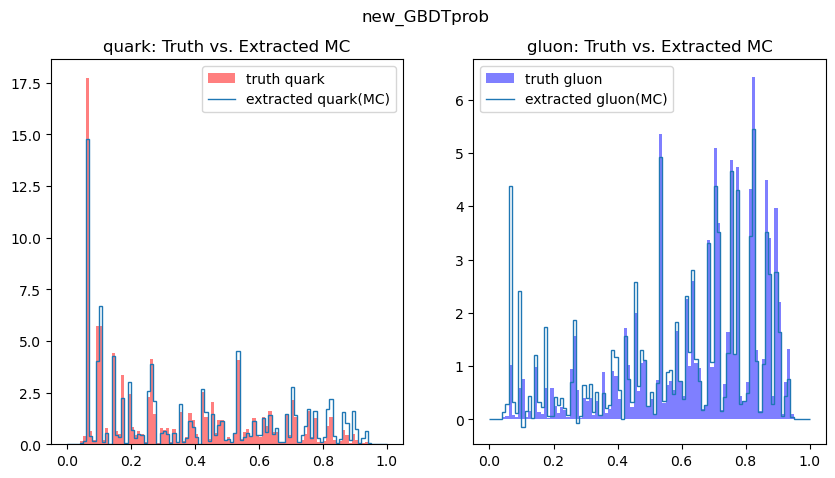

In [24]:
forward_quark = sample[(sample['is_forward']==1) &(sample['target']==0)]
forward_gluon = sample[(sample['is_forward']==1) &(sample['target']==1)]
central_quark = sample[(sample['is_forward']==0) &(sample['target']==0)]
central_gluon = sample[(sample['is_forward']==0) &(sample['target']==1)]
forward = sample[(sample['is_forward']==1)]
central = sample[(sample['is_forward']==0)]
quark = sample[sample['target']==0]
gluon = sample[sample['target']==1]

newbdt_bins = np.linspace(0.0, 1.0, 101)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
feature = 'new_GBDTprob'
ax[0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
          label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
ax[0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
          label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
ax[0].legend()
ax[0].set_title('quark: Forward vs. Central')

ax[1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
          label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
ax[1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
          label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
ax[1].set_title('gluon: Forward vs. Central')
ax[1].legend()
fig.suptitle(feature)




n_forward_quark = len(forward_quark)
n_central_quark = len(central_quark)
n_forward = len(forward)
n_central = len(central)

frac_forward_quark = n_forward_quark / n_forward
frac_central_quark = n_central_quark / n_central

frac_forward_gluon = 1 - frac_forward_quark
frac_central_gluon = 1 - frac_central_quark

f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
f_inv = np.linalg.inv(f)


# Do a simple extraction test
# MC closure 
feature = 'new_GBDTprob'
newbdt_bins = np.linspace(0.0, 1.0, 101)
hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)


extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
          label=f'truth quark', color='red', alpha = 0.5, density=True)
ax[0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
ax[0].legend()
ax[0].set_title('quark: Truth vs. Extracted MC')

ax[1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
          label=f'truth gluon', color='blue', alpha = 0.5, density=True)
ax[1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
ax[1].legend()
ax[1].set_title('gluon: Truth vs. Extracted MC')

fig.suptitle(feature)


## pt bins 

### GBDTprob distribution

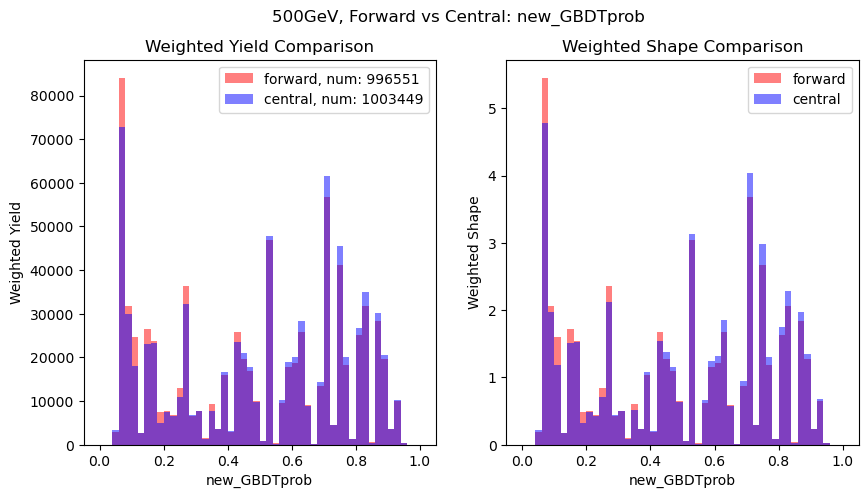

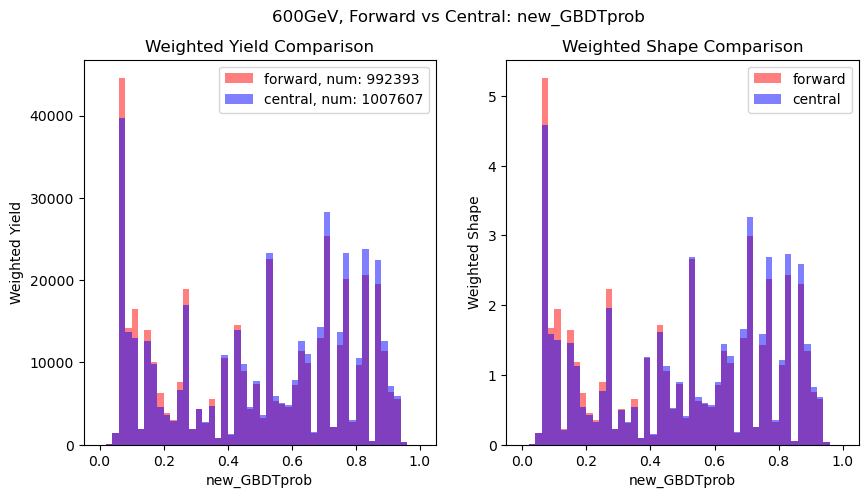

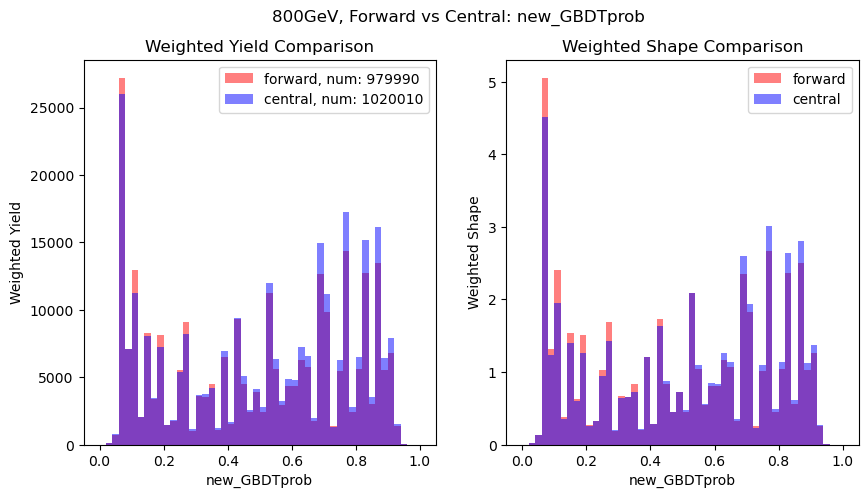

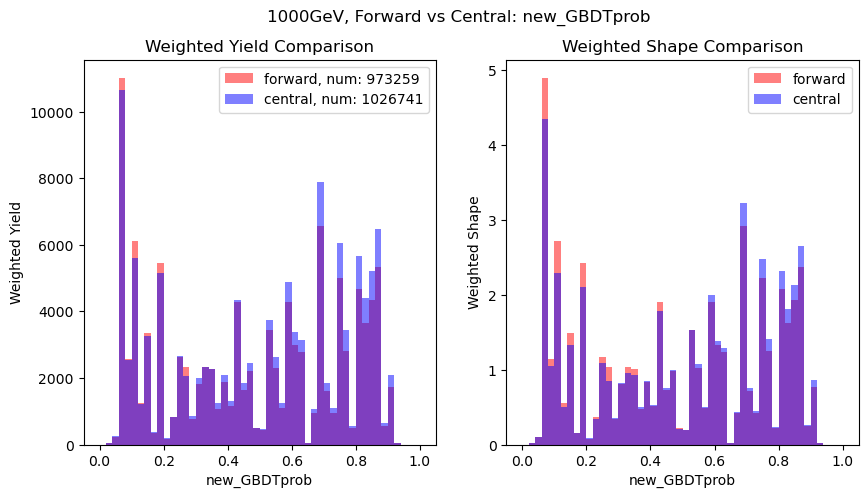

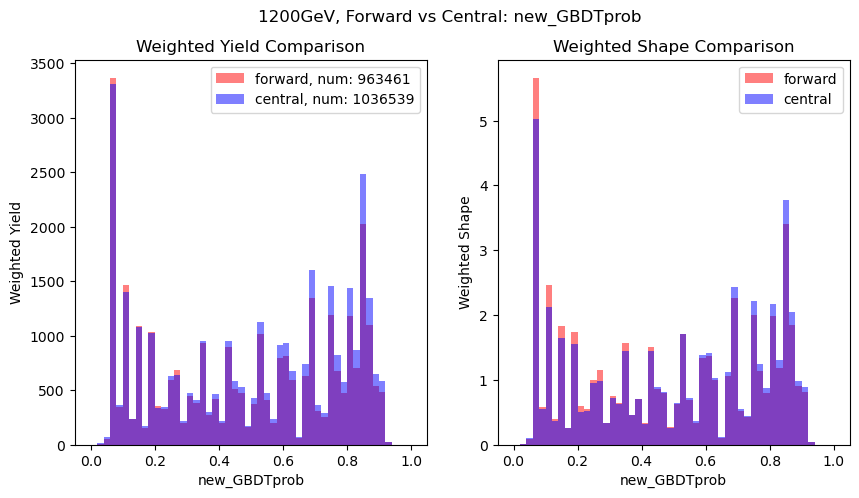

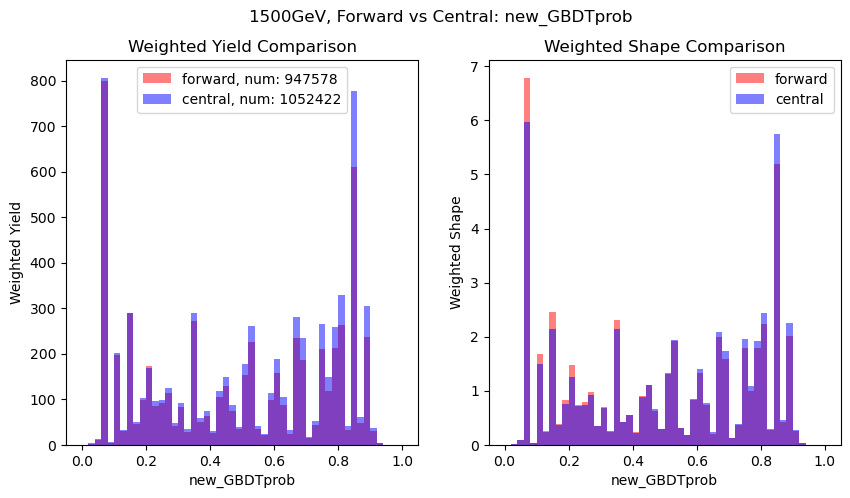

In [25]:
for pt_idx, pt in enumerate(label_pt_bin[:-1]):
    sample_pt = sample[sample['pt_idx'] == pt_idx] 

    sample_forward = sample_pt[sample_pt['is_forward']==1]
    sample_central = sample_pt[sample_pt['is_forward']==0]

    for feature_name in features[-1:]:
        custom_bins = HistBins[feature_name]
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
        ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
        ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'central, num: {len(sample_central)}', color='blue', alpha = 0.5)
        ax0.legend()
        ax0.set_xlabel(feature_name)
        ax0.set_ylabel(f"Weighted Yield")
        ax0.set_title(f"Weighted Yield Comparison")
        if feature_name == 'jet_pt':
            ax0.set_yscale('log')

        ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
        ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'central', color='blue', alpha = 0.5, density=True)
        ax1.legend()
        ax1.set_xlabel(feature_name)
        ax1.set_ylabel(f"Weighted Shape")
        ax1.set_title(f"Weighted Shape Comparison")
        if feature_name == 'jet_pt':
            ax1.set_yscale('log')
        fig.suptitle(f"{pt}GeV, Forward vs Central: {feature_name}")
        plt.plot()
    

### test extraction

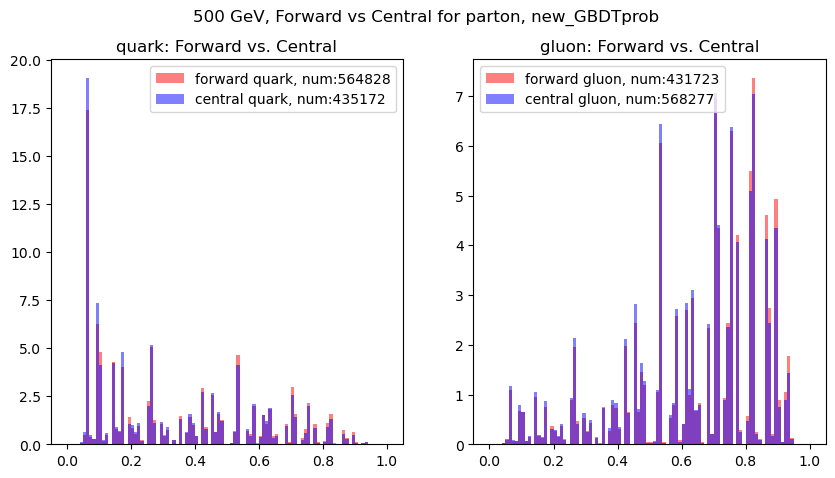

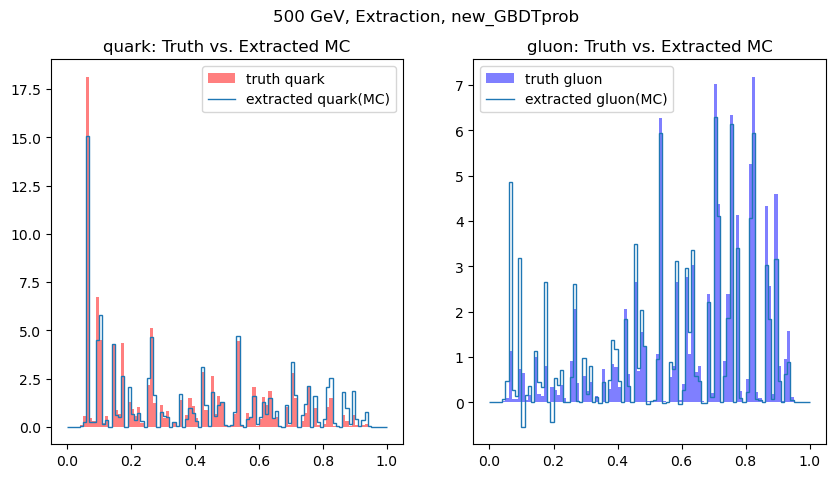

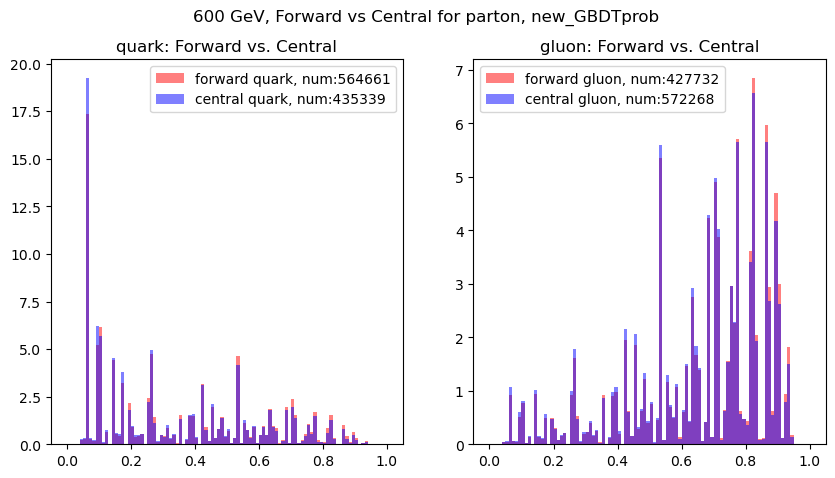

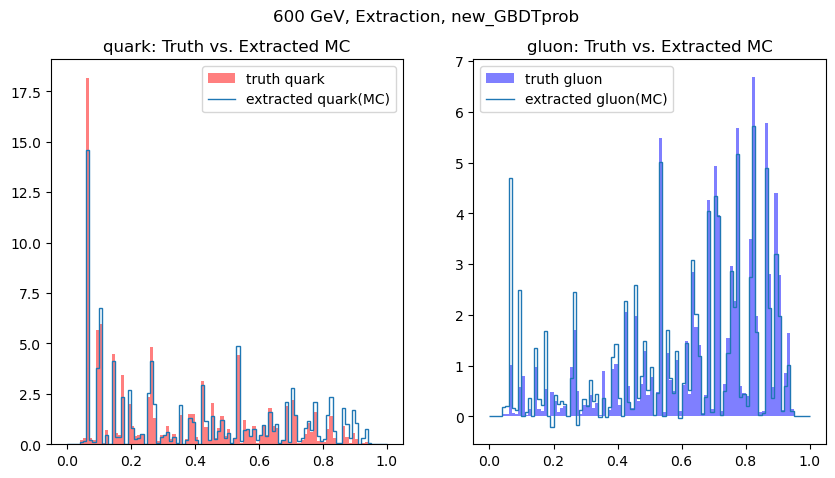

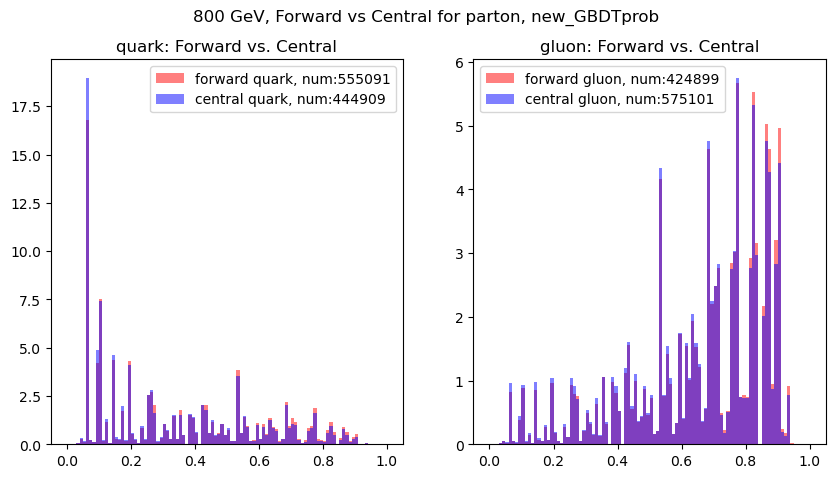

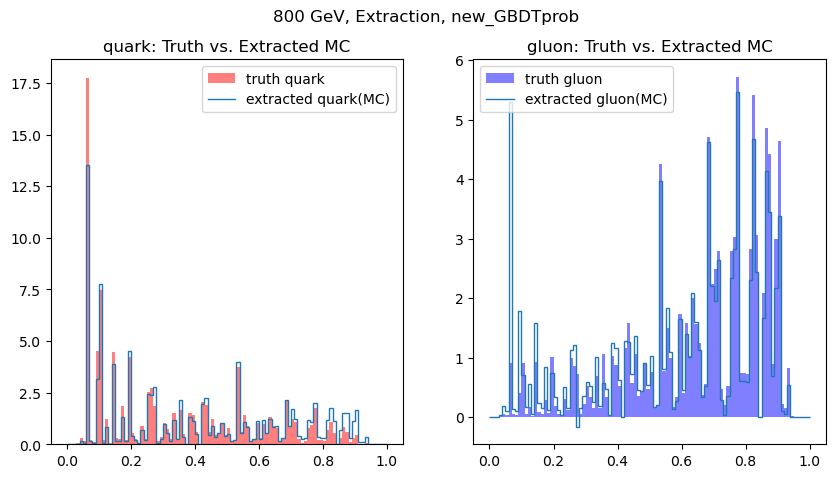

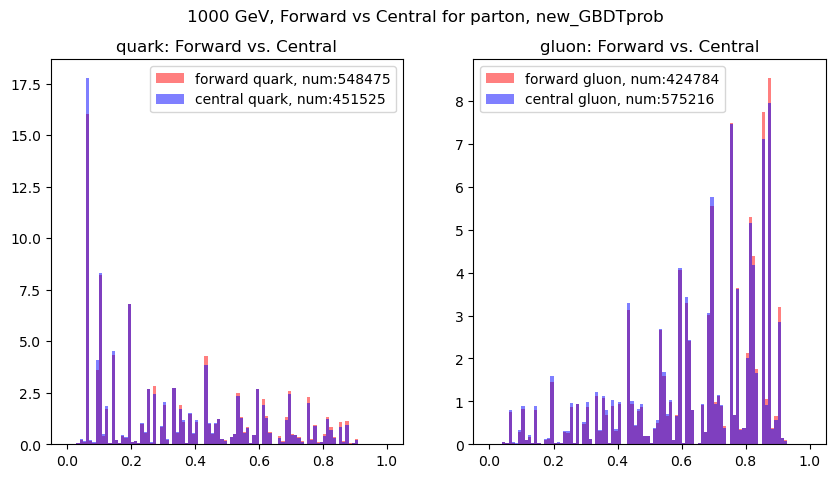

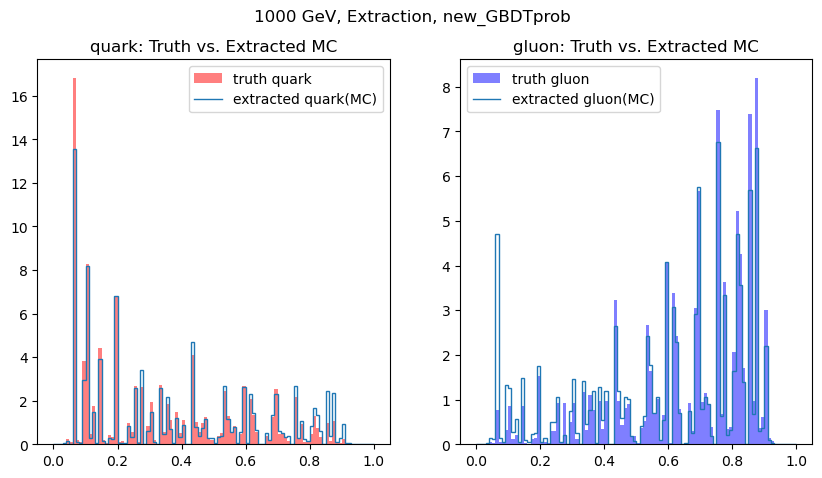

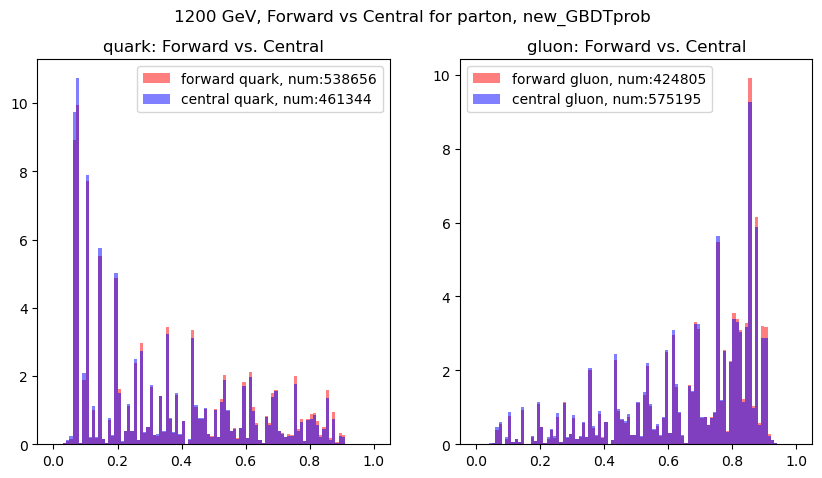

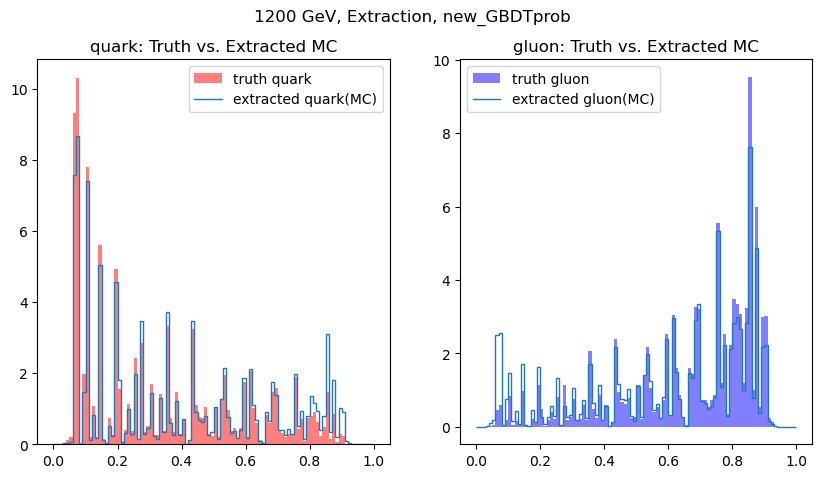

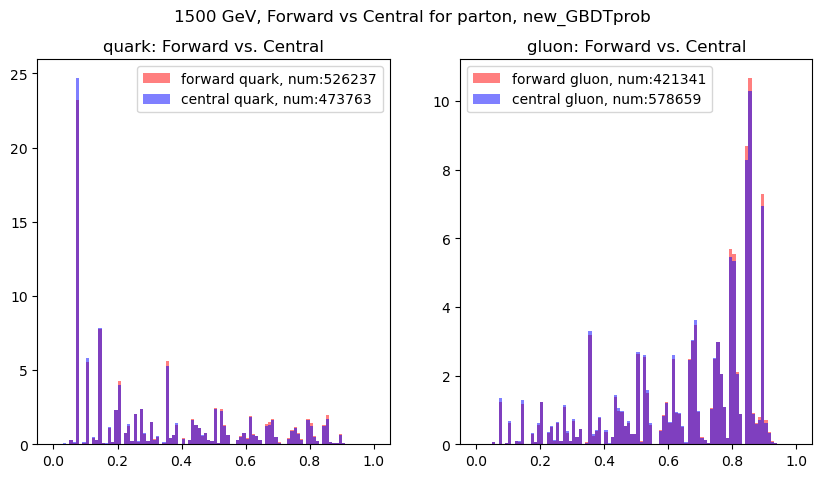

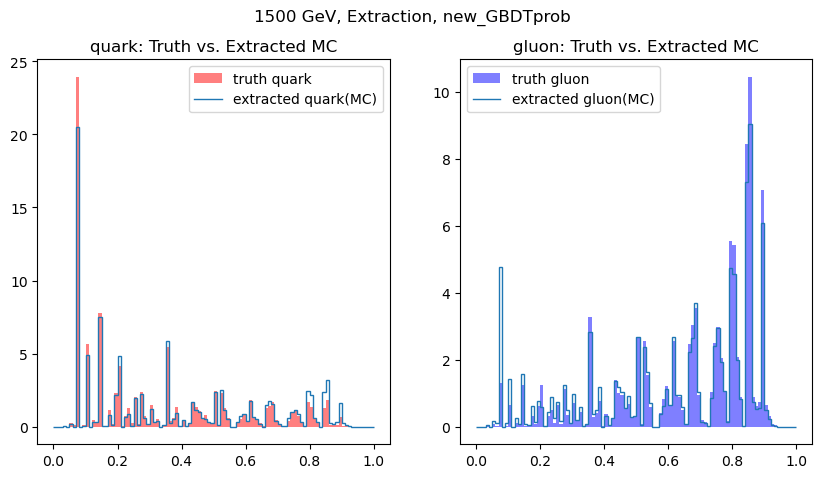

In [26]:
for pt_idx, pt in enumerate(label_pt_bin[:-1]):
    sample_pt = sample[sample['pt_idx'] == pt_idx] 
    _sample = sample_pt
    forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
    forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
    central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
    central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]
    forward = _sample[(_sample['is_forward']==1)]
    central = _sample[(_sample['is_forward']==0)]
    quark = _sample[_sample['target']==0]
    gluon = _sample[_sample['target']==1]

    newbdt_bins = np.linspace(0.0, 1.0, 101)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    feature = 'new_GBDTprob'
    ax[0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
            label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
    ax[0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
            label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
    ax[0].legend()
    ax[0].set_title('quark: Forward vs. Central')

    ax[1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
            label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
    ax[1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
            label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
    ax[1].set_title('gluon: Forward vs. Central')
    ax[1].legend()
    fig.suptitle(f"{pt} GeV, Forward vs Central for parton, {feature}")




    n_forward_quark = len(forward_quark)
    n_central_quark = len(central_quark)
    n_forward = len(forward)
    n_central = len(central)

    frac_forward_quark = n_forward_quark / n_forward
    frac_central_quark = n_central_quark / n_central

    frac_forward_gluon = 1 - frac_forward_quark
    frac_central_gluon = 1 - frac_central_quark

    f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
    f_inv = np.linalg.inv(f)


    # Do a simple extraction test
    # MC closure 
    feature = 'new_GBDTprob'
    newbdt_bins = np.linspace(0.0, 1.0, 101)
    hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
    hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)


    extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
    extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
            label=f'truth quark', color='red', alpha = 0.5, density=True)
    ax[0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
    ax[0].legend()
    ax[0].set_title('quark: Truth vs. Extracted MC')

    ax[1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
            label=f'truth gluon', color='blue', alpha = 0.5, density=True)
    ax[1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
    ax[1].legend()
    ax[1].set_title('gluon: Truth vs. Extracted MC')

    fig.suptitle(f"{pt} GeV, Extraction, {feature}")

# Test Extraction on whole period

In [31]:
with open(sample_all_jets_path, 'rb') as f:
    sample_all_jets = pd.read_pickle(f)

y_sample_all_jets = bdt.predict_proba(sample_all_jets[training_vars])[:,1]
sample_all_jets['new_GBDTprob'] = y_sample_all_jets
features = [*sample_all_jets.columns[:6]] + ['new_GBDTprob'] 
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-1.0, 1.0, 51), 
    features[6] : np.linspace(0.0, 1.0, 51),
}

_sample = sample_all_jets

## inclusive

### feature distribution

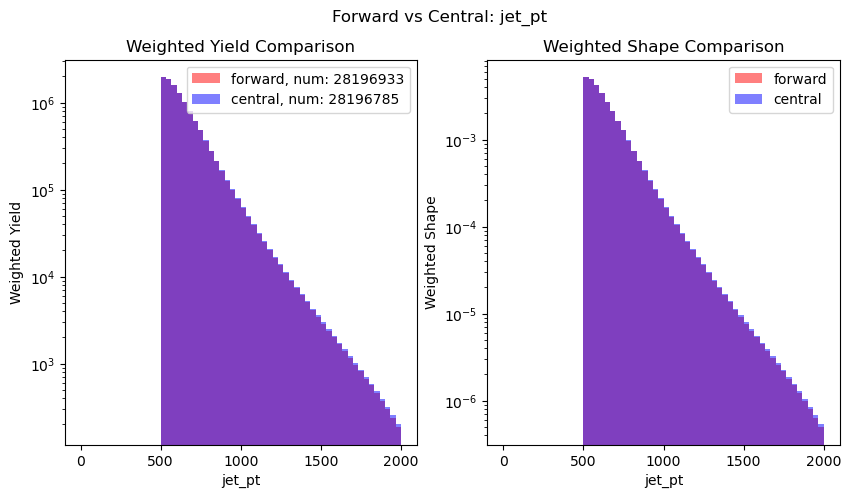

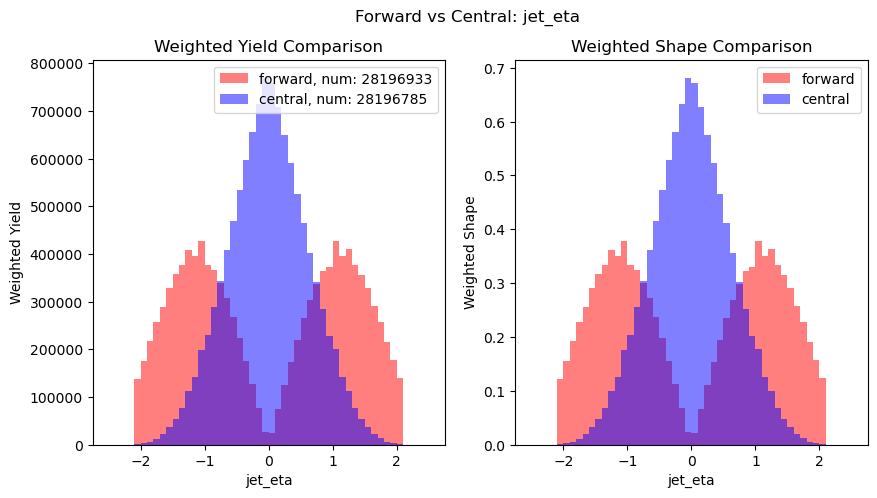

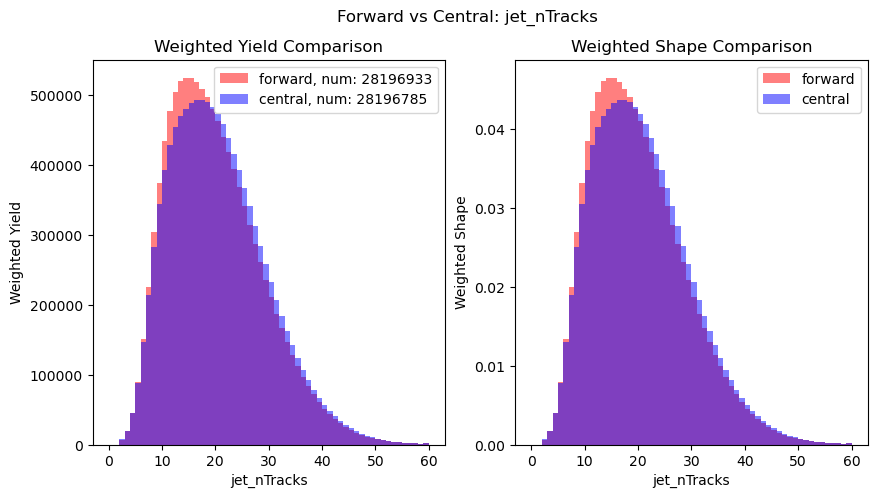

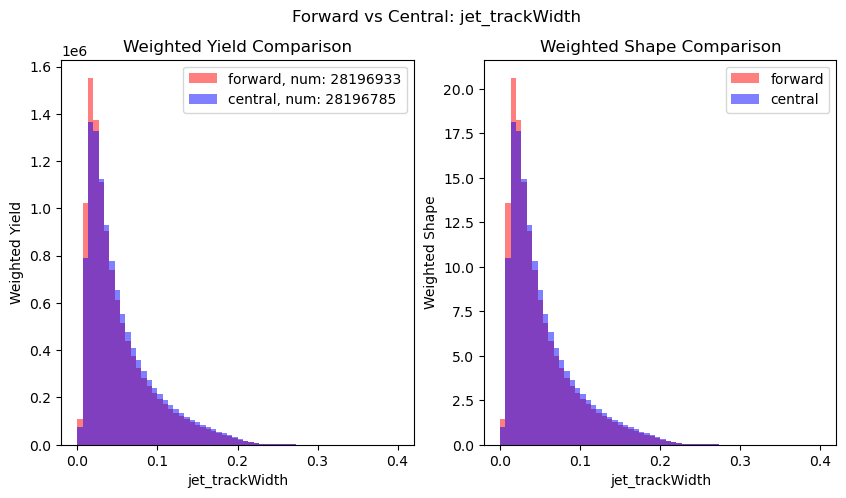

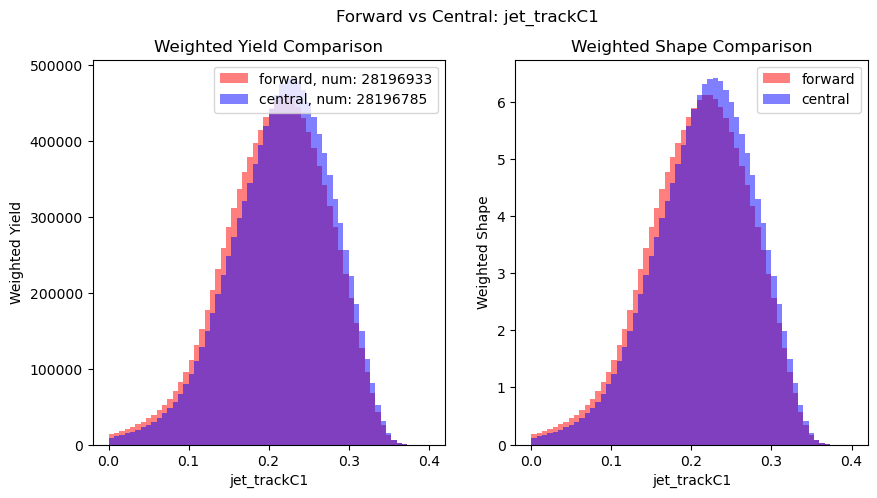

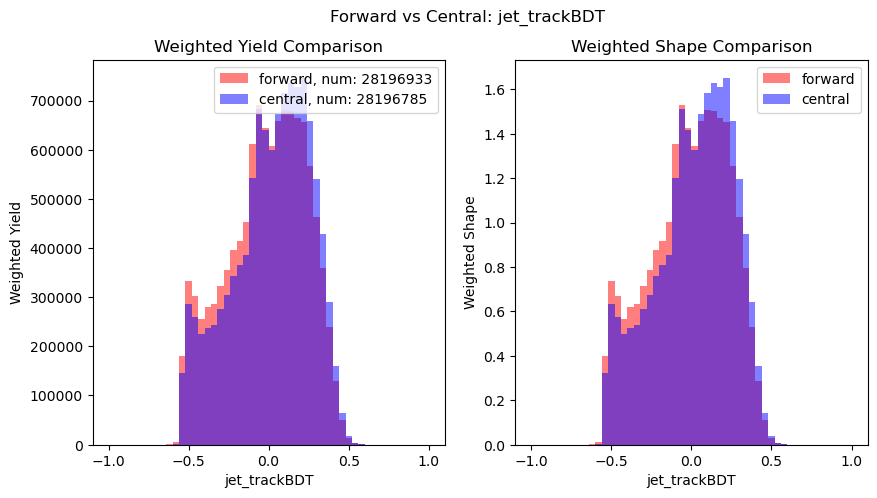

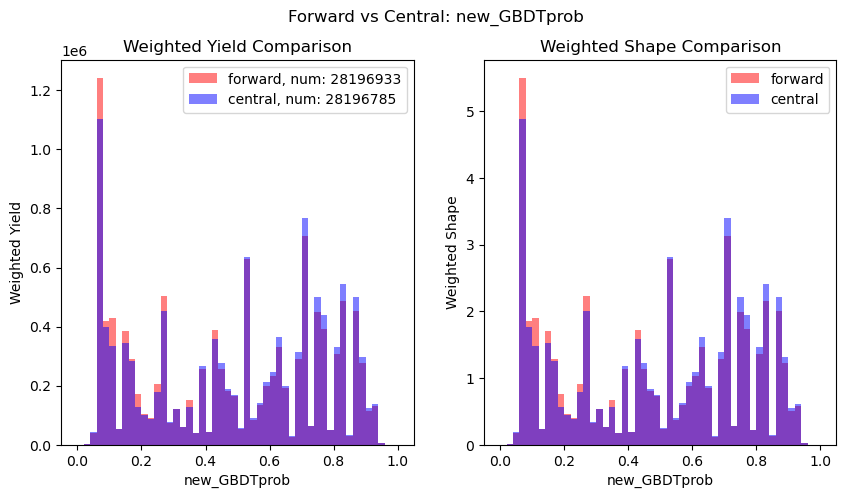

In [32]:
sample_forward = _sample[_sample['is_forward']==1]
sample_central = _sample[_sample['is_forward']==0]

for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
    ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'central, num: {len(sample_central)}', color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
    ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'central', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"Forward vs Central: {feature_name}")

    plt.plot()
    

### test extraction

Text(0.5, 0.98, 'new_GBDTprob')

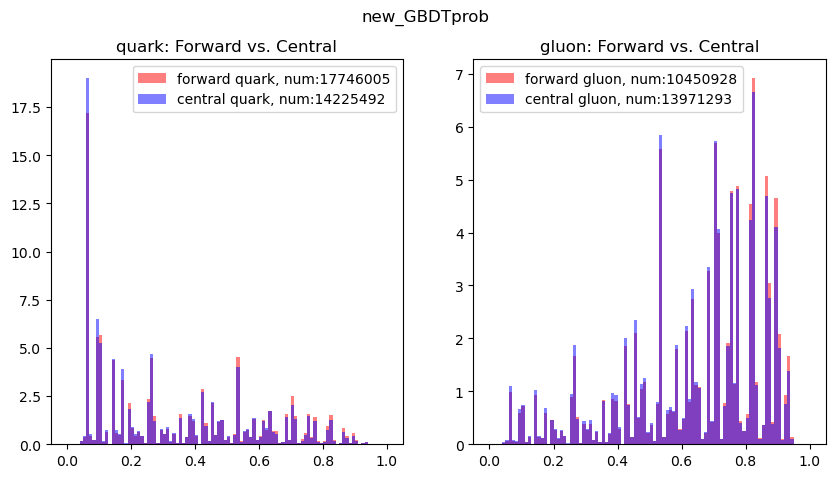

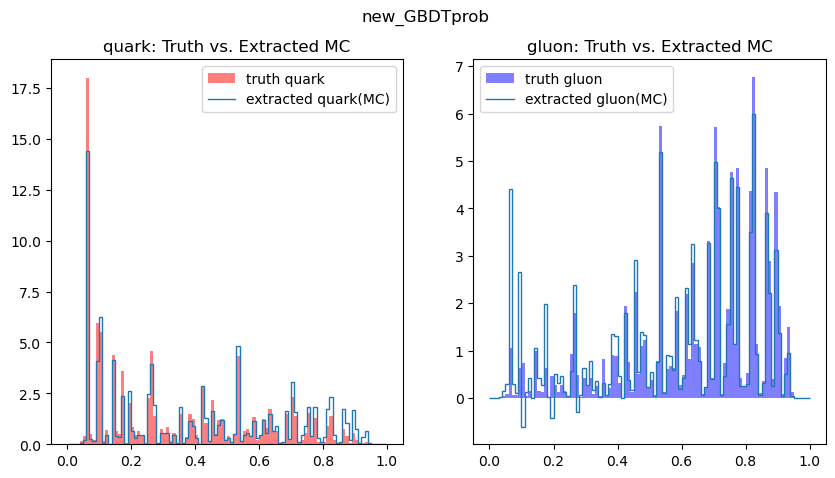

In [33]:
forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]
forward = _sample[(_sample['is_forward']==1)]
central = _sample[(_sample['is_forward']==0)]
quark = _sample[_sample['target']==0]
gluon = _sample[_sample['target']==1]

newbdt_bins = np.linspace(0.0, 1.0, 101)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
feature = 'new_GBDTprob'
ax[0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
        label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
ax[0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
        label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
ax[0].legend()
ax[0].set_title('quark: Forward vs. Central')

ax[1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
        label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
ax[1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
        label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
ax[1].set_title('gluon: Forward vs. Central')
ax[1].legend()
fig.suptitle(feature)


n_forward_quark = len(forward_quark)
n_central_quark = len(central_quark)
n_forward = len(forward)
n_central = len(central)

frac_forward_quark = n_forward_quark / n_forward
frac_central_quark = n_central_quark / n_central

frac_forward_gluon = 1 - frac_forward_quark
frac_central_gluon = 1 - frac_central_quark

f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
f_inv = np.linalg.inv(f)


# Do a simple extraction test
# MC closure 
feature = 'new_GBDTprob'
newbdt_bins = np.linspace(0.0, 1.0, 101)
hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)


extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
        label=f'truth quark', color='red', alpha = 0.5, density=True)
ax[0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
ax[0].legend()
ax[0].set_title('quark: Truth vs. Extracted MC')

ax[1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
        label=f'truth gluon', color='blue', alpha = 0.5, density=True)
ax[1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
ax[1].legend()
ax[1].set_title('gluon: Truth vs. Extracted MC')

fig.suptitle(feature)

## pt bins

### GBDTprob distribution

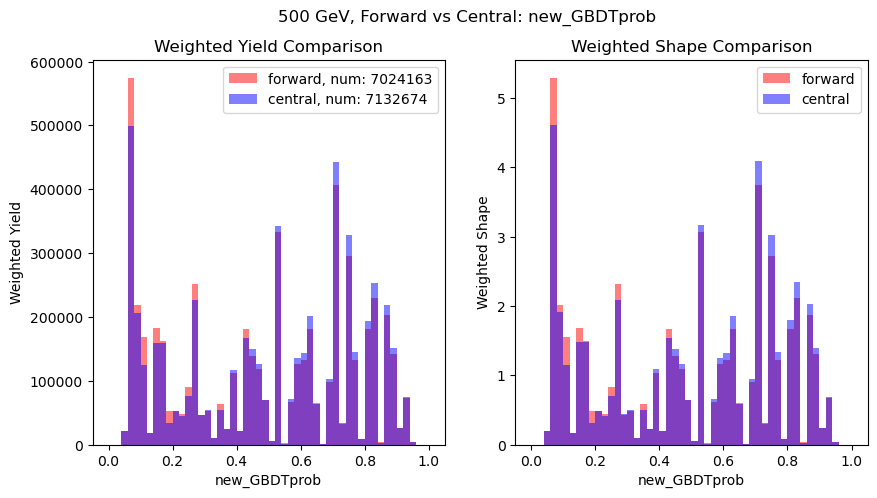

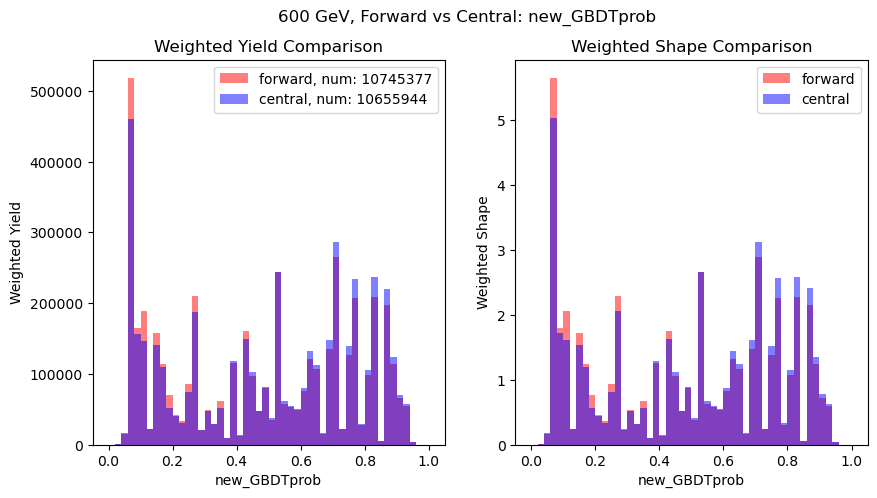

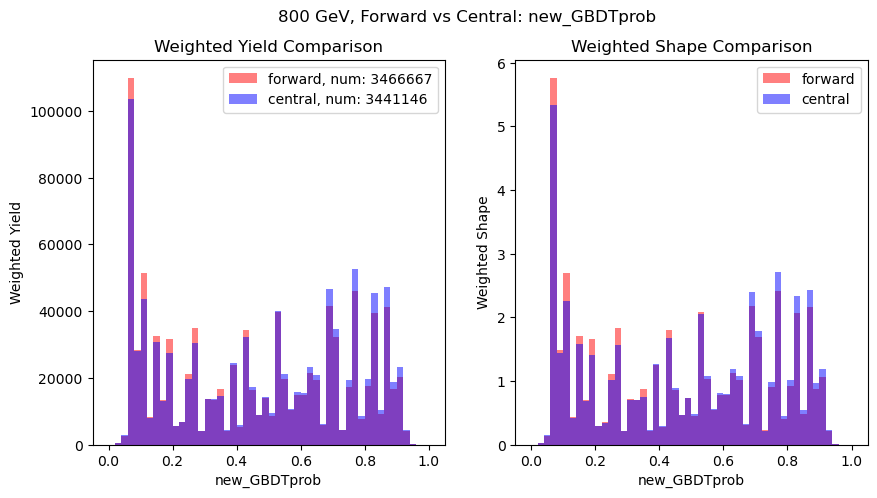

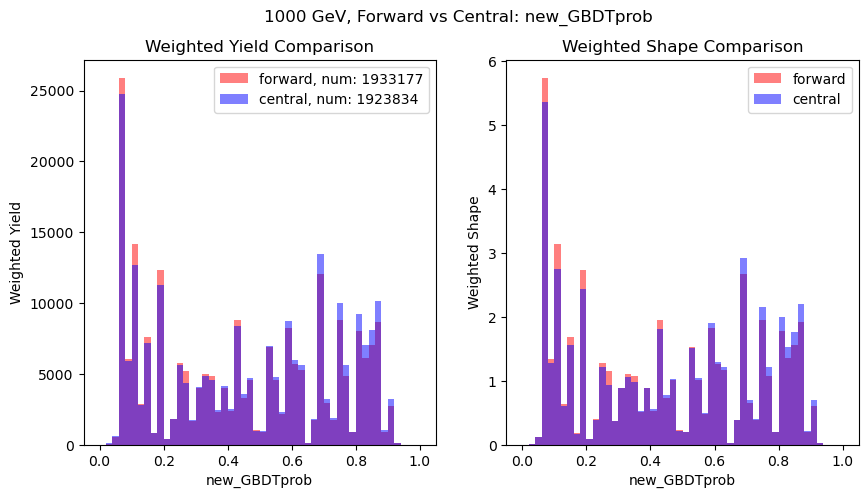

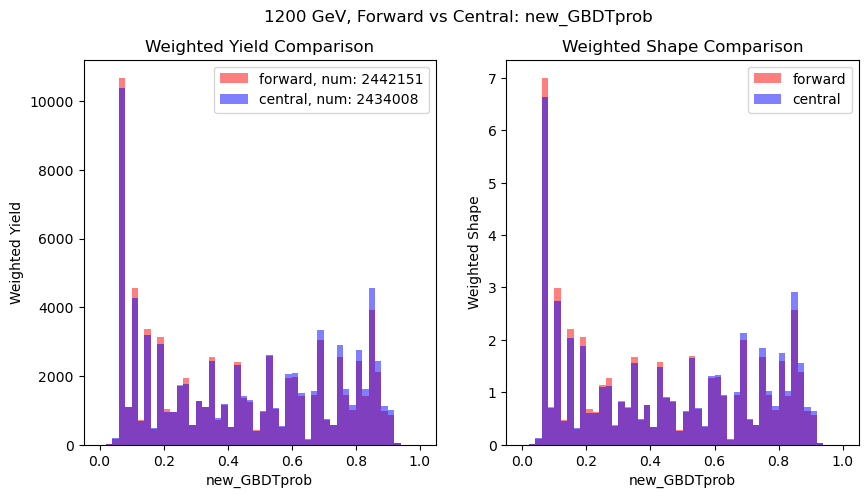

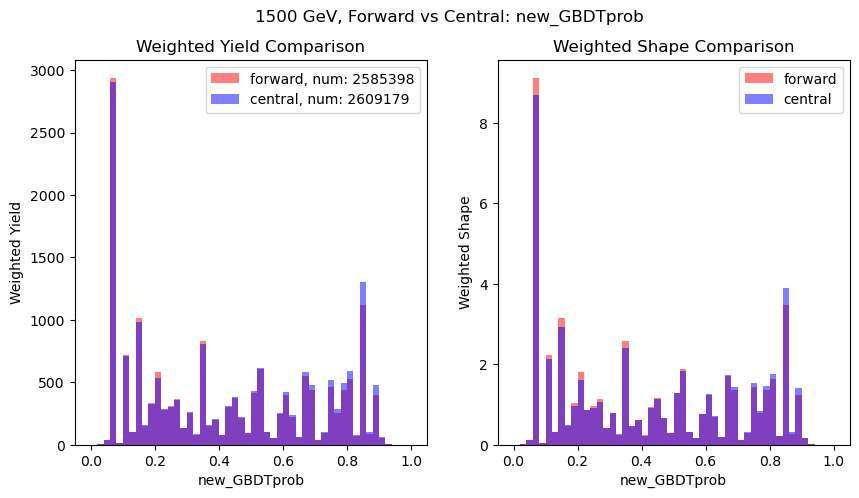

In [34]:
for pt_idx, pt in enumerate(label_pt_bin[:-1]):
    sample_pt = _sample[_sample['pt_idx'] == pt_idx] 

    sample_forward = sample_pt[sample_pt['is_forward']==1]
    sample_central = sample_pt[sample_pt['is_forward']==0]

    for feature_name in features[-1:]:
        custom_bins = HistBins[feature_name]
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
        ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
        ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'central, num: {len(sample_central)}', color='blue', alpha = 0.5)
        ax0.legend()
        ax0.set_xlabel(feature_name)
        ax0.set_ylabel(f"Weighted Yield")
        ax0.set_title(f"Weighted Yield Comparison")
        if feature_name == 'jet_pt':
            ax0.set_yscale('log')

        ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
        ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'central', color='blue', alpha = 0.5, density=True)
        ax1.legend()
        ax1.set_xlabel(feature_name)
        ax1.set_ylabel(f"Weighted Shape")
        ax1.set_title(f"Weighted Shape Comparison")
        if feature_name == 'jet_pt':
            ax1.set_yscale('log')
        fig.suptitle(f"{pt} GeV, Forward vs Central: {feature_name}")
        plt.plot()
    

### test extraction

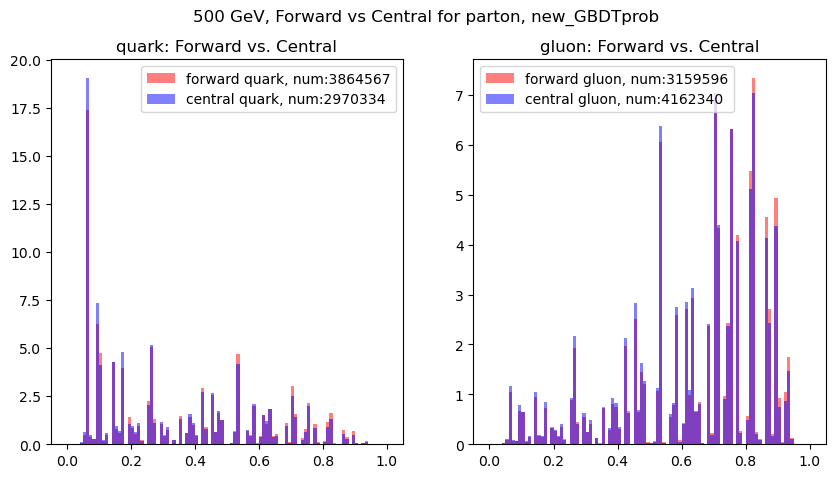

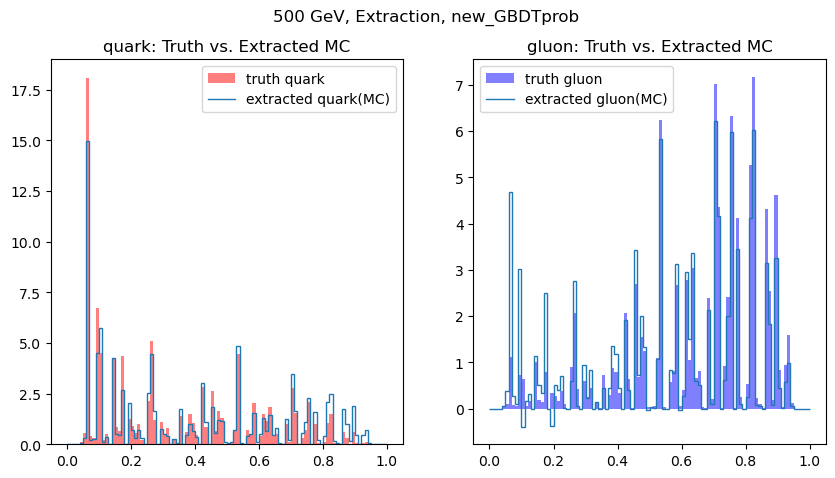

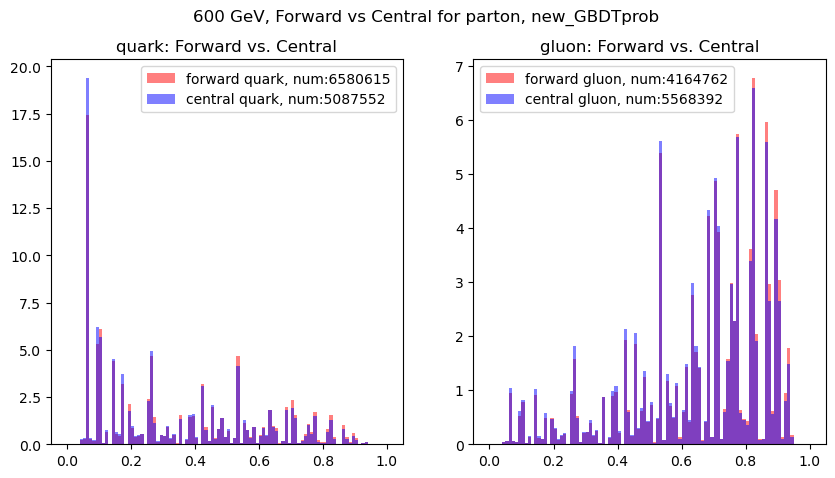

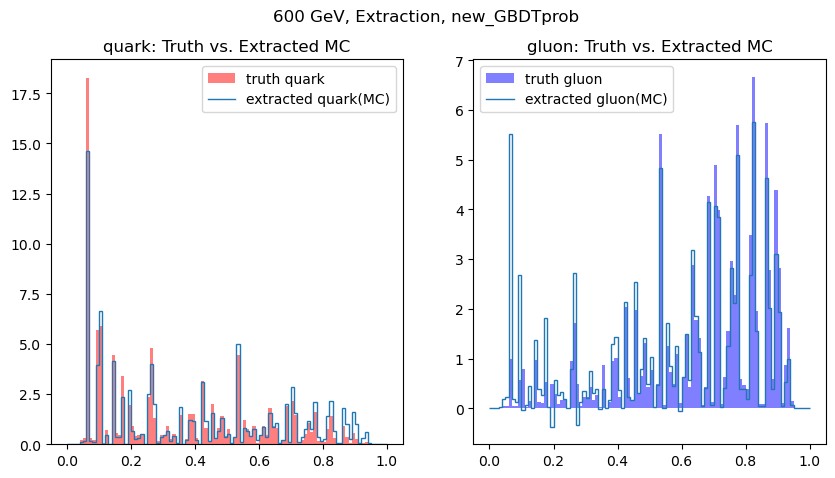

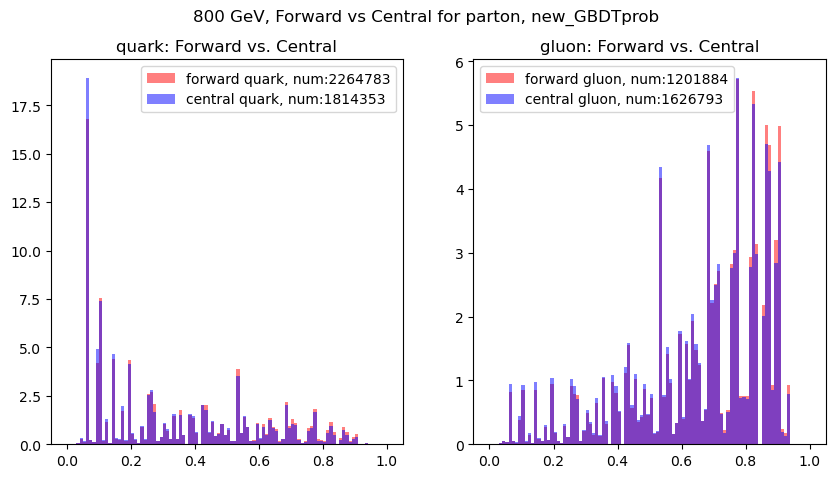

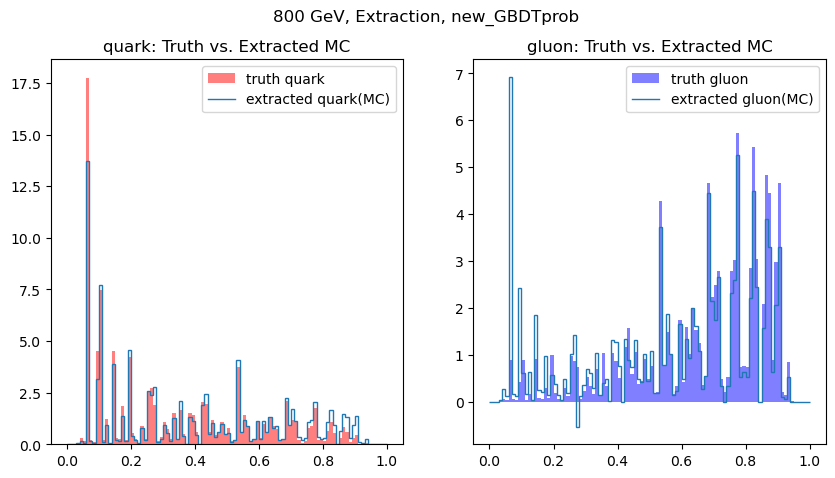

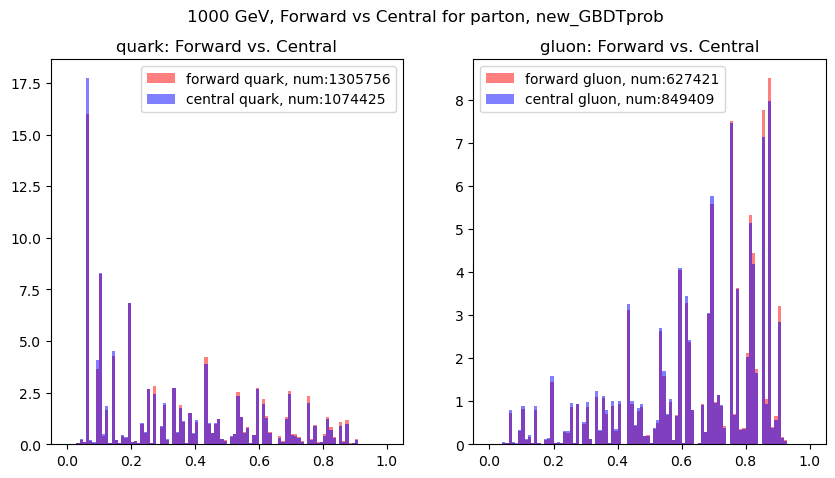

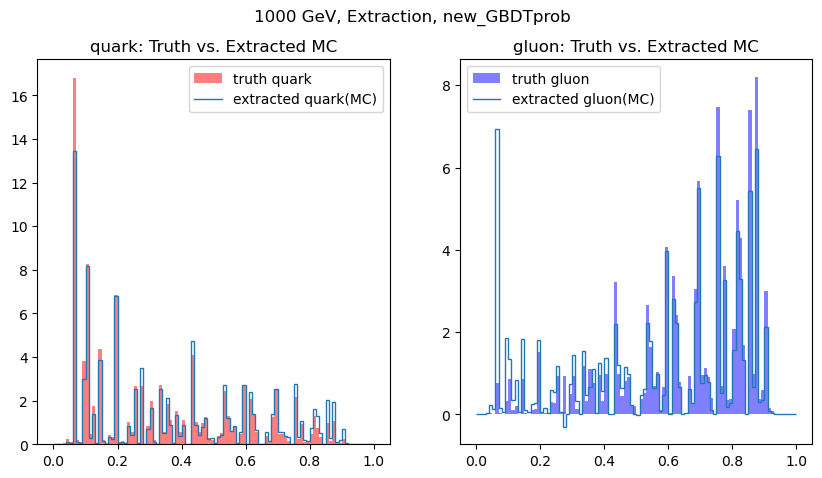

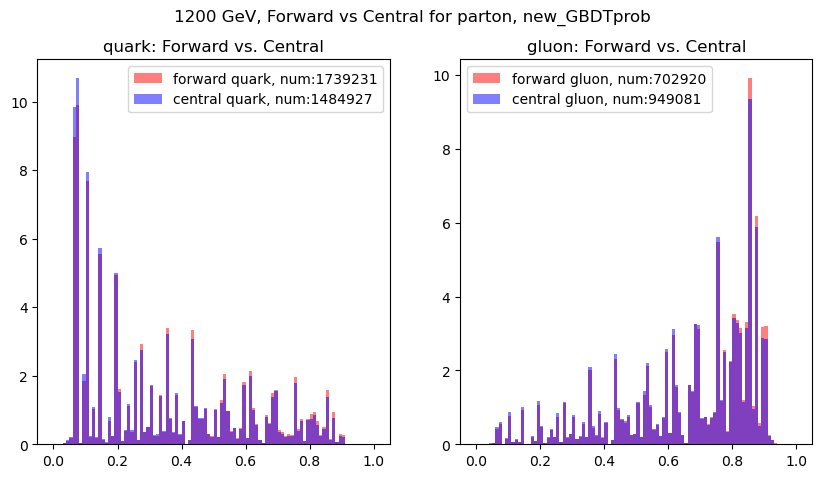

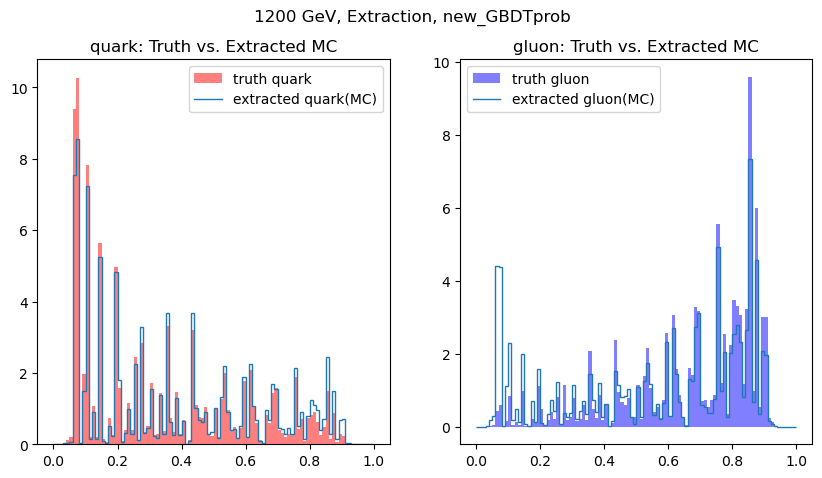

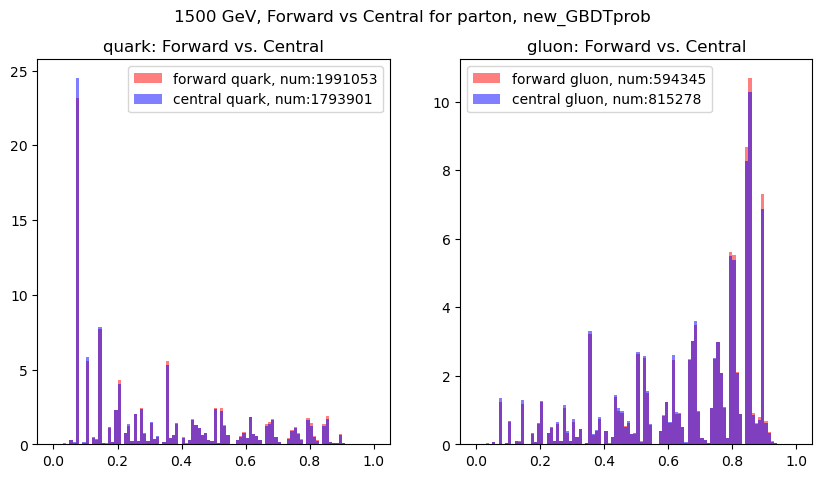

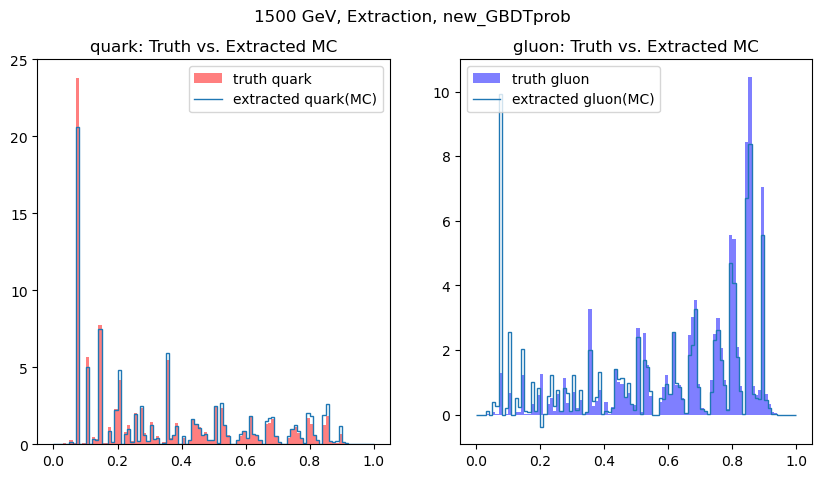

In [35]:
for pt_idx, pt in enumerate(label_pt_bin[:-1]):
    _sample_pt = _sample[_sample['pt_idx'] == pt_idx] 
    
    forward_quark = _sample_pt[(_sample_pt['is_forward']==1) &(_sample_pt['target']==0)]
    forward_gluon = _sample_pt[(_sample_pt['is_forward']==1) &(_sample_pt['target']==1)]
    central_quark = _sample_pt[(_sample_pt['is_forward']==0) &(_sample_pt['target']==0)]
    central_gluon = _sample_pt[(_sample_pt['is_forward']==0) &(_sample_pt['target']==1)]
    forward = _sample_pt[(_sample_pt['is_forward']==1)]
    central = _sample_pt[(_sample_pt['is_forward']==0)]
    quark = _sample_pt[_sample_pt['target']==0]
    gluon = _sample_pt[_sample_pt['target']==1]

    newbdt_bins = np.linspace(0.0, 1.0, 101)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    feature = 'new_GBDTprob'
    ax[0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
            label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
    ax[0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
            label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
    ax[0].legend()
    ax[0].set_title('quark: Forward vs. Central')

    ax[1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
            label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
    ax[1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
            label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
    ax[1].set_title('gluon: Forward vs. Central')
    ax[1].legend()
    fig.suptitle(f"{pt} GeV, Forward vs Central for parton, {feature}")




    n_forward_quark = len(forward_quark)
    n_central_quark = len(central_quark)
    n_forward = len(forward)
    n_central = len(central)

    frac_forward_quark = n_forward_quark / n_forward
    frac_central_quark = n_central_quark / n_central

    frac_forward_gluon = 1 - frac_forward_quark
    frac_central_gluon = 1 - frac_central_quark

    f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
    f_inv = np.linalg.inv(f)


    # Do a simple extraction test
    # MC closure 
    feature = 'new_GBDTprob'
    newbdt_bins = np.linspace(0.0, 1.0, 101)
    hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
    hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)


    extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
    extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
            label=f'truth quark', color='red', alpha = 0.5, density=True)
    ax[0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
    ax[0].legend()
    ax[0].set_title('quark: Truth vs. Extracted MC')

    ax[1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
            label=f'truth gluon', color='blue', alpha = 0.5, density=True)
    ax[1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
    ax[1].legend()
    ax[1].set_title('gluon: Truth vs. Extracted MC')

    fig.suptitle(f"{pt} GeV, Extraction, {feature}")